In [1]:
from coral.utils.data.load_data import get_dynamics_data, set_seed
from dynamics_dataset import TemporalDatasetWithCode
from utilities3 import *
import torch.nn.functional as F
from timeit import default_timer
import sys
from pathlib import Path
import hydra
from omegaconf import DictConfig, OmegaConf
import os
import wandb
from fourier_2d_time import FNO2d
import yaml

/home/kassai/code/coral/fno/fourier_2d_time.py:154: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config/", config_name="fno.yaml")


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import interp2d
import numpy as np

In [3]:
cfg = DictConfig(yaml.safe_load(open("config/fno.yaml")))
dataset_name = cfg.data.dataset_name

run_name = cfg.fno.run_name

root_dir = Path(os.getenv("WANDB_DIR")) / dataset_name

tmp = torch.load(root_dir / "fno" / f"{run_name}.pt")
cfg = tmp['cfg']

In [4]:
data_dir = cfg.data.dir
dataset_name = cfg.data.dataset_name
data_to_encode = cfg.data.data_to_encode
same_grid = cfg.data.same_grid
sub_tr = cfg.data.sub_tr
sub_te = cfg.data.sub_te
ntrain = cfg.data.ntrain
ntest = cfg.data.ntest
seq_inter_len = cfg.data.seq_inter_len
seq_extra_len = cfg.data.seq_extra_len

seed = cfg.data.seed

modes = cfg.fno.modes
width = cfg.fno.width

batch_size = cfg.optim.batch_size
learning_rate = cfg.optim.learning_rate
epochs = cfg.optim.epochs
scheduler_step = cfg.optim.scheduler_step
scheduler_gamma = cfg.optim.scheduler_gamma

In [5]:
random =  2 #np.random.randint(1, 8)

set_seed(seed)

sub_tes = [4, 2, 1]
preds = []
truths = []
################################################################
# load data and data normalization
################################################################
for sub_te in sub_tes:
    
    (u_train, u_eval_extrapolation, u_test, grid_tr, grid_tr_extra, grid_te) = get_dynamics_data(
        data_dir,
        dataset_name,
        ntrain,
        ntest,
        seq_inter_len=seq_inter_len,
        seq_extra_len=seq_extra_len,
        sub_tr=sub_tr,
        sub_te=sub_te,
        same_grid=same_grid,
    )

    print(f"data: {dataset_name}, u_train: {u_train.shape}, u_train_eval: {u_eval_extrapolation.shape}, u_test: {u_test.shape}")
    print(f"grid: grid_tr: {grid_tr.shape}, grid_tr_extra: {grid_tr_extra.shape}, grid_te: {grid_te.shape}")

    trainset = TemporalDatasetWithCode(
        u_train, grid_tr, 0, dataset_name, data_to_encode
    )

    trainset_out = TemporalDatasetWithCode(
        u_eval_extrapolation, grid_tr_extra, 0, dataset_name, data_to_encode
    )

    testset = TemporalDatasetWithCode(
        u_test, grid_te, 0, dataset_name, data_to_encode
    )

    mean, sigma = u_train.mean(), u_train.std()
    u_train = (u_train - mean) / sigma
    u_test = (u_test - mean) / sigma

    ntrain = u_train.shape[0]
    ntest = u_test.shape[0]

    train_loader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True, # TODO : here shuffle to False because error cuda (?!)
        num_workers=1,
        pin_memory=True,
    )

    valid_loader = torch.utils.data.DataLoader(
        trainset_out,
        batch_size=batch_size,
        shuffle=True, # TODO : here shuffle to False because error cuda (?!)
        num_workers=1,
        pin_memory=True,
    )

    test_loader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=True, # TODO : here shuffle to False because error cuda (?!)
        num_workers=1,
    )


    ################################################################
    # training and evaluation
    ################################################################
    model = FNO2d(modes, modes, width, 2).cuda()
    model.load_state_dict(tmp['fno'])
    model.eval()
    ground_truth, _, _ = test_loader.dataset[random - 1: random][0], test_loader.dataset[random - 1: random][1], test_loader.dataset[random - 1: random][2]

    ground_truth = ground_truth
    input_frame = ground_truth[..., 0].cuda()
    full_pred = [input_frame.cpu().detach()]
    for t in range(seq_extra_len+seq_inter_len - 1):
        pred = model(input_frame)
        input_frame = pred.detach()
        pred = pred.cpu().detach()
        ground_truth = ground_truth.cpu()
        full_pred.append(pred)
    preds.append(torch.stack(full_pred, dim = -1))
    truths.append(ground_truth)

data: shallow-water-dino, u_train: torch.Size([64, 64, 128, 2, 20]), u_train_eval: torch.Size([64, 64, 128, 2, 40]), u_test: torch.Size([8, 32, 64, 2, 40])
grid: grid_tr: torch.Size([64, 64, 128, 3, 20]), grid_tr_extra: torch.Size([64, 64, 128, 3, 40]), grid_te: torch.Size([8, 32, 64, 3, 40])
data: shallow-water-dino, u_train: torch.Size([64, 64, 128, 2, 20]), u_train_eval: torch.Size([64, 64, 128, 2, 40]), u_test: torch.Size([8, 64, 128, 2, 40])
grid: grid_tr: torch.Size([64, 64, 128, 3, 20]), grid_tr_extra: torch.Size([64, 64, 128, 3, 40]), grid_te: torch.Size([8, 64, 128, 3, 40])
data: shallow-water-dino, u_train: torch.Size([64, 64, 128, 2, 20]), u_train_eval: torch.Size([64, 64, 128, 2, 40]), u_test: torch.Size([8, 128, 256, 2, 40])
grid: grid_tr: torch.Size([64, 64, 128, 3, 20]), grid_tr_extra: torch.Size([64, 64, 128, 3, 40]), grid_te: torch.Size([8, 128, 256, 3, 40])


In [15]:
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import interp2d
import numpy as np

def gif_baselines(plot_dir, title, preds, truths, channel, view=(100., 0.)):
    
    T = preds[0].shape[-1]
    ims = []
    proj = ccrs.Orthographic(*view)

    # add subfigure per subplot
    fig = plt.figure(constrained_layout=True)
    subfigs = fig.subfigures(nrows=3, ncols=1)

    # clear subplots

    latitude1 = torch.linspace(90.0, -90.0, truths[0].shape[1])
    longitude1 = torch.linspace(0.0, 360.0 - (360.0 / truths[0].shape[2]), truths[0].shape[2])
    longitude_grid1, latitude_grid1 = torch.meshgrid(longitude1, latitude1, indexing="xy")

    latitude2 = torch.linspace(90.0, -90.0, truths[1].shape[1])
    longitude2 = torch.linspace(0.0, 360.0 - (360.0 / truths[1].shape[2]), truths[1].shape[2])
    longitude_grid2, latitude_grid2 = torch.meshgrid(longitude2, latitude2, indexing="xy")

    latitude3 = torch.linspace(90.0, -90.0, truths[2].shape[1])
    longitude3 = torch.linspace(0.0, 360.0 - (360.0 / truths[2].shape[2]), truths[2].shape[2])
    longitude_grid3, latitude_grid3 = torch.meshgrid(longitude3, latitude3, indexing="xy")
    
    axes = subfigs[0].subplots(1, 2, subplot_kw={'projection': proj})
    subfigs[1].suptitle('Sub_te = 4')
    axs = subfigs[1].subplots(1, 2, subplot_kw={'projection': proj})
    subfigs[1].suptitle('Sub_te = 2')
    ax = subfigs[2].subplots(1, 2, subplot_kw={'projection': proj})
    subfigs[2].suptitle('Sub_te = 1')

    for i in range(T):
        print(i)
        if i < 20:
            time = 'In-t'
            im0 = axes[0].pcolormesh(longitude_grid1, latitude_grid1, truths[0][0, ..., channel, i],
                                transform=ccrs.PlateCarree(), cmap='viridis', shading = 'auto')
            axes[0].set_title('Ground truth')
            axes[0].gridlines(linewidth=1, color='black', alpha=0.05)

            im1 = axes[1].pcolormesh(longitude_grid1, latitude_grid1, preds[0][0, ..., channel, i],
                                        transform=ccrs.PlateCarree(), cmap='viridis', shading = 'auto')
            axes[1].gridlines(linewidth=1, color='black', alpha=0.05)
            axes[1].set_title('Reconstruction')

            im2 = axs[0].pcolormesh(longitude_grid2, latitude_grid2, truths[1][0, ..., channel, i],
                                        transform=ccrs.PlateCarree(), cmap='viridis', shading = 'auto')
            axs[0].set_title('Ground truth')
            axs[0].gridlines(linewidth=1, color='black', alpha=0.05)

            im3 = axs[1].pcolormesh(longitude_grid2, latitude_grid2, preds[1][0, ..., channel, i],
                                        transform=ccrs.PlateCarree(), cmap='viridis', shading = 'auto')
            axs[1].gridlines(linewidth=1, color='black', alpha=0.05)
            axs[1].set_title('Reconstruction')

            im4 = ax[0].pcolormesh(longitude_grid3, latitude_grid3, truths[2][0, ..., channel, i],
                                        transform=ccrs.PlateCarree(), cmap='viridis', shading = 'auto')
            ax[0].set_title('Ground truth, {}'.format(time))
            ax[0].gridlines(linewidth=1, color='black', alpha=0.05)

            im5 = ax[1].pcolormesh(longitude_grid3, latitude_grid3, preds[2][0, ..., channel, i],
                                        transform=ccrs.PlateCarree(), cmap='viridis', shading = 'auto')
            ax[1].gridlines(linewidth=1, color='black', alpha=0.05)
            ax[1].set_title('Reconstruction')
            ims.append([im0, im1, im2, im3, im4, im5])
        elif i >= 20:
            time = 'Out-t'

            im0 = axes[0].pcolormesh(longitude_grid1, latitude_grid1, truths[0][0, ..., channel, i],
                                        transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
            axes[0].set_title('Ground truth')
            axes[0].gridlines(linewidth=1, color='black', alpha=0.05)

            im1 = axes[1].pcolormesh(longitude_grid1, latitude_grid1, preds[0][0, ..., channel, i],
                                        transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
            axes[1].gridlines(linewidth=1, color='black', alpha=0.05)
            axes[1].set_title('Reconstruction')

            im2 = axs[0].pcolormesh(longitude_grid2, latitude_grid2, truths[1][0, ..., channel, i],
                                        transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
            axs[0].set_title('Ground truth')
            axs[0].gridlines(linewidth=1, color='black', alpha=0.05)

            im3 = axs[1].pcolormesh(longitude_grid2, latitude_grid2, preds[1][0, ..., channel, i],
                                        transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
            axs[1].gridlines(linewidth=1, color='black', alpha=0.05)
            axs[1].set_title('Reconstruction')

            im4 = ax[0].pcolormesh(longitude_grid3, latitude_grid3, truths[2][0, ..., channel, i],
                                        transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
            ax[0].set_title('Ground truth')
            ax[0].gridlines(linewidth=1, color='black', alpha=0.05)

            im5 = ax[1].pcolormesh(longitude_grid3, latitude_grid3, preds[2][0, ..., channel, i],
                                        transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
            ax[1].gridlines(linewidth=1, color='black', alpha=0.05)
            ax[1].set_title('Reconstruction')
            ims.append([im0, im1, im2, im3, im4, im5])

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                    repeat_delay=1000)

    ani.save(os.path.join(plot_dir, title),
            dpi=300)  # , writer=PillowWriter(fps=25))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


MovieWriter ffmpeg unavailable; using Pillow instead.


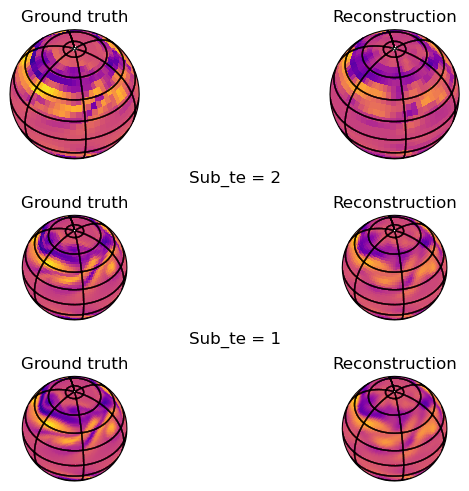

In [16]:
gif_baselines('/home/kassai/code/coral/template/', 'predictions_fno.gif', preds, truths, channel = 1, view = (-10, 45))

In [11]:
pred_train_inter_mse = 0.0
pred_train_extra_mse = 0.0
pred_test_inter_mse = 0.0
pred_test_extra_mse = 0.0
myloss = nn.MSELoss()

with torch.no_grad():
    for u_batch, modulations, coord_batch, idx in valid_loader:
        u_batch = u_batch.cuda()
        coord_batch = coord_batch.cuda()
        input_frame = u_batch[..., 0]
        batch_size = u_batch.shape[0]

        for t in range(seq_extra_len+seq_inter_len - 1):
            target_frame = u_batch[..., t+1]
            pred = model(input_frame)
            loss = myloss(pred.view(batch_size, -1),
                            target_frame.view(batch_size, -1))
            # test_l2 += loss.item()
            xx = pred * sigma.cuda() + mean.cuda()
            yy = target_frame * sigma.cuda() + mean.cuda()

            # We don't use the first timesteps to compute the extrapolation loss
            if t >= seq_inter_len:
                pred_train_extra_mse += ((xx.view(batch_size, -1) -
                                    yy.view(batch_size, -1))**2).mean()*batch_size
            if t < seq_inter_len:
                pred_train_inter_mse += ((xx.view(batch_size, -1) -
                                        yy.view(batch_size, -1))**2).mean()*batch_size

            input_frame = pred.detach()

    for u_batch, modulations, coord_batch, idx in test_loader:
        u_batch = u_batch.cuda()
        coord_batch = coord_batch.cuda()
        input_frame = u_batch[..., 0]
        batch_size = u_batch.shape[0]

        for t in range(seq_extra_len+seq_inter_len - 1):
            target_frame = u_batch[..., t+1]
            pred = model(input_frame)
            loss = myloss(pred.view(batch_size, -1),
                            target_frame.view(batch_size, -1))
            # test_l2 += loss.item()
            xx = pred * sigma.cuda() + mean.cuda()
            yy = target_frame * sigma.cuda() + mean.cuda()

            # We don't use the first timesteps to compute the extrapolation loss
            if t >= seq_inter_len:
                pred_test_extra_mse += ((xx.view(batch_size, -1) -
                                yy.view(batch_size, -1))**2).mean()*batch_size
            if t < seq_inter_len:
                pred_test_inter_mse += ((xx.view(batch_size, -1) -
                                yy.view(batch_size, -1))**2).mean()*batch_size        

            input_frame = pred.detach()

pred_train_inter_mse /= (ntrain*(seq_inter_len-1))
pred_train_extra_mse /= (ntrain*(seq_extra_len-1))
pred_test_inter_mse /= (ntest*(seq_inter_len-1))
pred_test_extra_mse /= (ntest*(seq_extra_len-1))

In [12]:
print("pred_train_inter_mse : ", pred_train_inter_mse.item())
print('pred_train_extra_mse :' , pred_train_extra_mse.item())

pred_train_inter_mse :  5.620122465188615e-05
pred_train_extra_mse : 0.0001053407322615385


In [13]:
print("pred_test_inter_mse : ", pred_test_inter_mse.item())
print('pred_test_extra_mse :' , pred_test_extra_mse.item())

pred_test_inter_mse :  6.913499237271026e-05
pred_test_extra_mse : 0.00015221245121210814
